# Trends in variability



In [1]:
import os
import sys
import warnings
import xarray as xr
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from odc.geo.xr import assign_crs
from xarrayMannKendall import Mann_Kendall_test

warnings.simplefilter('ignore')
import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords

%matplotlib inline

## Analysis Parameters

In [9]:
base = '/g/data/os22/chad_tmp/AusENDVI/data/'
crs='EPSG:4326'

## Open datasets

In [10]:
pku = xr.open_dataarray(f'{base}/NDVI_harmonization/AVHRR_GIMMS-PKU-MODIS_1982_2022.nc').sel(time=slice('1982', '2013'))
pku = pku.rename('NDVI')
pku = assign_crs(pku, crs=crs)
pku.attrs['nodata'] = np.nan

gimms = xr.open_dataset(base+'NDVI_harmonization/AVHRR_GIMMS3g_v1.1_1982_2013.nc')['NDVI']
gimms = assign_crs(gimms, crs='epsg:3577')
gimms.attrs['nodata'] = np.nan

gimmsv2 = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/GIMMS3g_v1.2_1982_2022.nc')['ndvi']
gimmsv2 = assign_crs(gimmsv2, crs='EPSG:4326')

ds = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022_0.2.0.nc')['AusENDVI_clim_MCD43A4']
ds = assign_crs(ds, crs='EPSG:4326')
ds = ds.rename('NDVI')
ds.attrs['nodata'] = np.nan
ds = ds.sel(time=slice('2000','2022'))

ds_clim = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_gapfilled_1982_2013_0.2.0.nc')['AusENDVI_clim']
ds_clim = assign_crs(ds_clim, crs='EPSG:4326')
ds_clim = ds_clim.rename('NDVI')
ds_clim.attrs['nodata'] = np.nan

ls = xr.open_dataset(base+'/NDVI_harmonization/Landsat_NDVI_5km_monthly_1988_2012.nc')['NDVI']
ls = assign_crs(ls, crs=crs)
ls.attrs['nodata'] = np.nan

# rain = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/rain_5km_monthly_1981_2022.nc').rain
# rain = rain.sel(time=slice('1982', '2022'))
# rain = assign_crs(rain, crs=crs)
# rain.attrs['nodata'] = np.nan

## Harmonise

In [13]:
ds = ds.odc.reproject(pku.odc.geobox, resampling='average')
ds_clim = ds_clim.odc.reproject(pku.odc.geobox, resampling='average')
gimms = gimms.odc.reproject(pku.odc.geobox, resampling='nearest')
gimmsv2 = gimmsv2.odc.reproject(pku.odc.geobox, resampling='nearest')
ls = ls.odc.reproject(pku.odc.geobox, resampling='average')

gimms = round_coords(gimms)
gimmsv2 = round_coords(gimmsv2)
ds = round_coords(ds)
ds_clim = round_coords(ds_clim)
pku = round_coords(pku)
ls = round_coords(ls)

#gapfill PKU the same as our product
pku_clim = pku.groupby('time.month').mean()
pku = pku.fillna(pku_clim).drop_vars(['month', 'spatial_ref']).isel(month=1)

# GIMMS3g gapfill with climatology
gimms_clim = gimms.groupby('time.month').mean()
gimms = gimms.fillna(gimms_clim).drop_vars(['month', 'spatial_ref']).isel(month=1)

#gimms v1.2
gimms_v2_clim = gimmsv2.groupby('time.month').mean()
gimmsv2 = gimmsv2.fillna(gimms_v2_clim).drop_vars(['month', 'spatial_ref']).isel(month=1)

#Landsat
obs_monthly = ls.groupby('time.month').mean()
obs_anom = ls.groupby('time.month') - obs_monthly
obs_anom = obs_anom.interpolate_na(dim='time', method='linear', limit=1)
ls = obs_anom.groupby('time.month') + obs_monthly
ls = ls.drop('month')
ls = ls.groupby("time.month").fillna(obs_monthly)

## Mask

In [14]:
mask = ~np.isnan(ds.mean('time'))
ls = ls.where(mask)
ds = ds.where(mask)
gimms = gimms.where(mask)
gimmsv2 = gimmsv2.where(mask)
pku = pku.where(mask)

## Calculate coefficient in variation

Following: https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2023EF004119

In [15]:
gimms_1d = gimms.resample(time='YS').mean()
gimmsv2_1d = gimmsv2.resample(time='YS').mean()
ds_1d = ds.resample(time='YS').mean()
ds_clim_1d = ds_clim.resample(time='YS').mean()

pku_1d = pku.resample(time='YS').mean()
ls_1d = ls.resample(time='YS').mean()
# modis_1d = ds_1d.sel(time=slice('2000','2022'))

In [16]:
roll=10
min = 10
c=True
# modis_cv = modis_1d.rolling(time=roll, center=c, min_periods=min).std() / modis_1d.rolling(time=roll, center=c, min_periods=min).mean()
ds_cv = ds_1d.rolling(time=roll, center=c, min_periods=min).std() / ds_1d.rolling(time=roll, center=c, min_periods=min).mean()
ds_clim_cv = ds_clim_1d.rolling(time=roll, center=c, min_periods=min).std() / ds_clim_1d.rolling(time=roll, center=c, min_periods=min).mean()
pku_cv = pku_1d.rolling(time=roll, center=c, min_periods=min).std() / pku_1d.rolling(time=roll, center=c, min_periods=min).mean()
gimms_cv = gimms_1d.rolling(time=roll, center=c, min_periods=min).std() / gimms_1d.rolling(time=roll, center=c, min_periods=min).mean()
gimmsv2_cv = gimmsv2_1d.rolling(time=roll, center=c, min_periods=min).std() / gimmsv2_1d.rolling(time=roll, center=c, min_periods=min).mean()
ls_cv = ls_1d.rolling(time=roll, center=c, min_periods=min).std() / ls_1d.rolling(time=roll, center=c, min_periods=min).mean()

#remove extreme values that might skew results
gimms_cv = xr.where((gimms_cv>5) | (gimms_cv<0), np.nan, gimms_cv)
pku_cv = xr.where((pku_cv>5) | (pku_cv<0), np.nan, pku_cv)
ds_cv = xr.where((ds_cv>5) | (ds_cv<0), np.nan, ds_cv)
ds_clim_cv = xr.where((ds_clim_cv>5) | (ds_clim_cv<0), np.nan, ds_clim_cv)

## Trends in CV averaged over Aus.

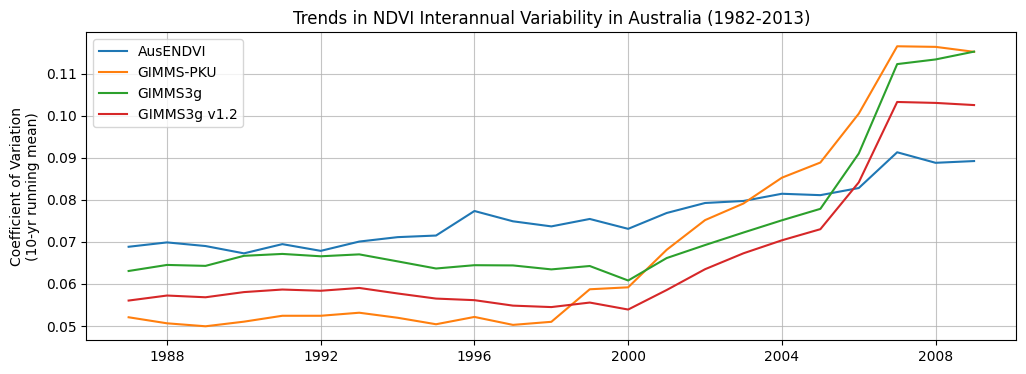

In [26]:
# with plt.style.context('ggplot'):
fig,ax = plt.subplots(1,1, figsize=(12, 4))
# ds_cv.where(mask).mean(['latitude', 'longitude']).sel(time=slice('1982','2013')).plot(ax=ax, label='MODIS MCD43A4')
ds_clim_cv.where(mask).mean(['latitude', 'longitude']).sel(time=slice('1982','2009')).plot(ax=ax, label='AusENDVI')
pku_cv.where(mask).mean(['latitude', 'longitude']).sel(time=slice('1982','2009')).plot(ax=ax, label='GIMMS-PKU')
gimms_cv.where(mask).mean(['latitude', 'longitude']).sel(time=slice('1982','2009')).plot(ax=ax, label='GIMMS3g')
gimmsv2_cv.where(mask).mean(['latitude', 'longitude']).sel(time=slice('1982','2009')).plot(ax=ax, label='GIMMS3g v1.2')
ax.set_xlabel(None)
ax.set_title('Trends in NDVI Interannual Variability in Australia (1982-2013)')
ax.set_ylabel('Coefficient of Variation\n(10-yr running mean)')
ax.legend()
ax.grid(alpha=0.75)

fig.savefig("/g/data/os22/chad_tmp/Aus_phenology/results/figs/CV_trends_1d.png",
            bbox_inches='tight', dpi=300)